In [8]:
%matplotlib inline

In [9]:
import os
from google.cloud import bigquery
import bq_helper
import numpy_stats

In [12]:
os.environ['GOOGLE_CRED_DIR']=os.path.join(os.environ['HOME'],'creds')
os.environ['GOOGLE_APPLICATION_CREDENTIALS']=os.path.join(os.environ['GOOGLE_CRED_DIR'],'apt-footing-235018-aeb185ac9e31.json')

In [ ]:
github_repos.list_tables()

In [ ]:
api_results = bq_helper.BigQueryHelper(active_project= "apt-footing-235018", 
                                       dataset_name = "NumpyAPI")

Query Constructed for API functions..  

In [ ]:
### AFter copying and pasting the above query into BigQuery and saving as sample_results... 

In [ ]:
#Pull data from bigQuery
#r = api_results.query_to_pandas_safe('SELECT * FROM `apt-footing-235018.NumpyAPI.sample_results`')
#r

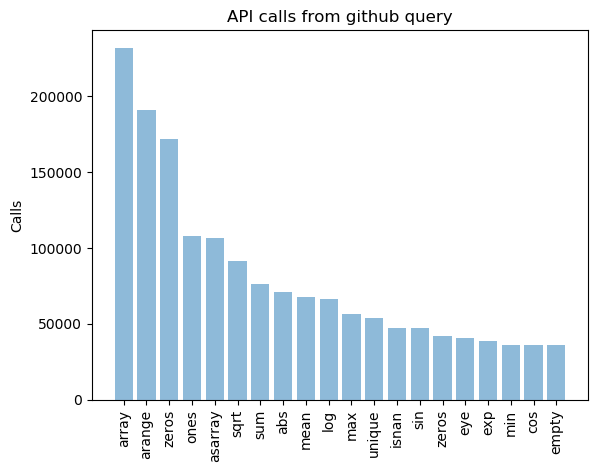

In [16]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
import pandas as pd
#r = pd.read_csv('results-20190322-101605.csv').T
r = pd.read_csv('full_results2.csv').T

r2 = r.loc[r[0]>0].sort_values(0,ascending=False)
r2.index = [ f.split('_')[1] for f in list(r2.index)]


r2 = r2[:20]
y_pos = np.arange(len(r2))
calls = r2[0]
 
plt.bar(y_pos, calls, align='center', alpha=0.5)
plt.xticks(y_pos,r2.index,rotation='vertical')

plt.ylabel('Calls')
plt.title('API calls from github query')

fig1 = plt.gcf() 
plt.show()
fig1.savefig('results2.png', dpi=100)

In [17]:
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('results2.png', dpi=100)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [92]:
import numpy

In [93]:
methods =  [x for x in dir(numpy.zeros((3,3))) if not x.startswith('__')]

In [95]:
api = [(x, type(numpy.__getattribute__(x))) for x in dir(numpy) if not x.startswith('__')]

In [96]:
ufuncs = [x for x in api if x[1] is numpy.ufunc]

In [97]:
functions = [x for x in api if x[1] is type(lambda x: x)]

In [98]:
builtins = [x for x in api if x[1] is type(numpy.zeros)]

In [102]:
api_things = list(set(x[1] for x in api))

In [103]:
api_grouped = {y:[x[0] for x in api if x[1] is y] for y in api_things}

In [ ]:
api_grouped